In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

## Sample
Megan Bedell made an awesome cross-match available, which was online by the time I woke up on West Coast!

Let's match this to the McQuillan+2014 rotation catalog using Pandas & a join

In [3]:
Gfile = '../data/kepler_dr2_1arcsec.fits' # from http://gaia-kepler.fun, thanks to M. Bedell
data = Table.read(Gfile, format='fits')

In [4]:
gaia = data.to_pandas()
gaia.shape

(195830, 101)

In [55]:
# gaia.columns.values

Text(0,0.5,u'Bailer-Jones distance (pc)')

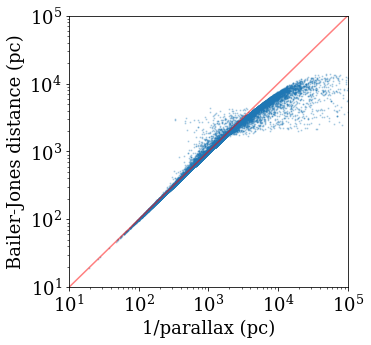

In [54]:
plt.figure(figsize=(5,5))

pok = np.where((gaia[u'r_modality_flag'] ==1) & (gaia[u'r_result_flag'] ==1))
plt.scatter(1000./gaia[u'parallax'].values[pok], gaia['r_est'].values[pok], s=1, alpha=0.25)

plt.plot([1,1e5], [1,1e5], c='r', alpha=0.5)
plt.xlim(10,1e5)
plt.ylim(10,1e5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('1/parallax (pc)')
plt.ylabel('Bailer-Jones distance (pc)')

In [7]:
rot_file = '../data/Table_Periodic.txt'
rot = pd.read_csv(rot_file)
rot.shape

(34030, 11)

In [8]:
df = pd.merge(rot, gaia, right_on='kepid', left_on='KID')
df.shape

(33538, 112)

In [9]:
df.columns.values

array(['KID', 'Teff', 'logg_x', 'Mass', 'Prot', 'Prot_err', 'Rper', 'LPH',
       'w', 'DC', 'Flag', 'designation', 'source_id', 'gaia_ref_epoch',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr',
       'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr',
       'pmra_pmdec_corr', 'astrometric_chi2_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig',
       'astrometric_primary_flag', 'duplicated_source',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'bp_rp', 'bp_g', 'g_rp', 'radial_velocity',
       'radial_velocity_error', 'phot_variable_flag', 'l', 'b', 'ec

## Quality Cuts
we need to trim the sample to get the best distances

In [11]:
ok = np.where(np.isfinite(df[u'parallax']) & # this is basically the same as the TGAS file...
              (df[u'parallax_error'] < 0.1) &
              (gaia[u'r_modality_flag'] == 1) & 
              (gaia[u'r_result_flag'] == 1) &
              np.isfinite(df[u'bp_rp']) & 
              (df[u'phot_bp_mean_flux_error']/df[u'phot_bp_mean_flux'] < 0.01) & 
              (df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01) & 
              (df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01))[0]

ok.shape

(30305,)

## The Gaia-Kepler Rotation CMD

We have 3 flavors of Isochrones to consider here:
- My normal go to, PARSEC
- the MIST set, which #gaiadr2 folks prefer & are based on MESA models
- YaPSI, which are all about rotation, but probably don't have colors we want

Text(0,0.5,u'$M_R$ (mag)')

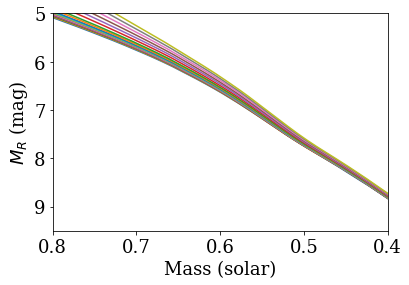

In [185]:
#   YaPSI - wrong bands, so work in relative sense...
Ynames = ('Age', 'M/Msun', 'logT', 'logL/Ls', 'logg', 'Mv', 'U-B', 'B-V', 'V-R', 'V-I', 'J-K', 'H-K', 'V-K')
Yfile = '../iso/YaPSI/WL11/yapsi_w_X0p685018_Z0p004982.dat'

yapsi = pd.read_table(Yfile, names=Ynames, comment='#', delim_whitespace=True)

yok = np.where( (yapsi['Age'] > 0.1) & (yapsi['Age'] < 10))
for aa in np.unique(yapsi['Age'].values[yok]):
    aok = np.where((yapsi['Age'].values[yok] == aa))
    
    plt.plot(yapsi['M/Msun'].values[yok][aok], yapsi['Mv'].values[yok][aok] - yapsi['V-R'].values[yok][aok])
plt.ylim(9.5,5)
plt.xlim(0.8, 0.4)
plt.xlabel('Mass (solar)')
plt.ylabel('$M_R$ (mag)')

In [12]:
#  PARSEC ISOCHRONE

## Isochrones w/ Gaia mags
# output195874734622.dat # age = 1e8
# output783328222883.dat # age = 1e9
# output382961170123.dat # age = 5e9

isonames = ('Zini','Age','Mini','Mass','logL','logTe','logg','label','McoreTP',
            'C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo',
            'Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag','B_Tmag','V_Tmag',
            'Jmag','Hmag','Ksmag')

iso_file = '../iso/parsec/output783328222883.dat'  # age = 1e9
iso = pd.read_table(iso_file, delim_whitespace=True, header=None, comment='#', names=isonames)
iso1e8 = pd.read_table('../iso/parsec/output195874734622.dat', delim_whitespace=True, header=None, comment='#', names=isonames)
iso5e9 = pd.read_table('../iso/parsec/output382961170123.dat', delim_whitespace=True, header=None, comment='#', names=isonames)


isonames2 = ('Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 
             'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 
             'Xo', 'Cexcess', 'Z', 'mbolmag', 'Umag', 'Bmag', 'Vmag', 'Rmag', 'Imag', 'Jmag', 'Hmag', 'Kmag'
)
iso_file2 = '../iso/parsec/output632510793236.dat' # a 1e9 isochrone w/ UBVRIJHK mags
iso2 = pd.read_table(iso_file2, delim_whitespace=True, header=None, comment='#', names=isonames2)

# get just the main sequence, and reverse it (for interpolating later)
iok = np.where((iso['label'] < 2) & (iso['Gmag'] > 1.7))[0][::-1]

In [197]:
#  MIST isochrones
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = '../iso/mist/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
#MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

mist_ms1 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] == 9.))
mist_ms2 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] > 8.11) & (mist['log10_isochrone_age_yr'] < 8.2))

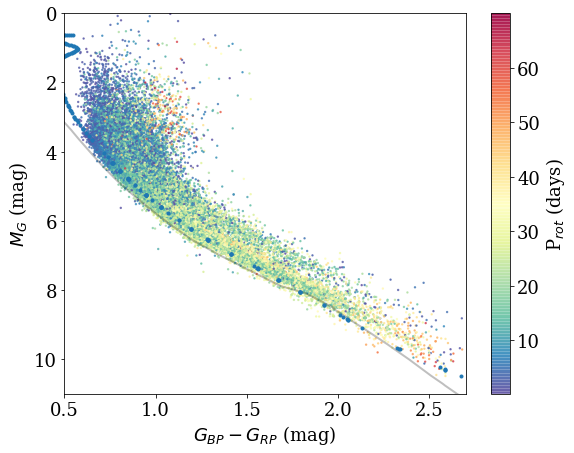

In [198]:
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral_r')

plt.scatter(df[u'bp_rp'].values[ok], 
            df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
            c=(df[u'Prot'].values[ok]), alpha=0.7, s=2, cmap=cm)

plt.plot(iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok], iso['Gmag'].values[iok], 
         c='k', lw=2, alpha=0.25)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], '.')
# plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms2] - mist['Gaia_RP_DR2Rev'].values[mist_ms2], 
#          mist['Gaia_G_DR2Rev'].values[mist_ms2], '.')


plt.ylim(11,0)
plt.xlim(.5,2.7)
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('P$_{rot}$ (days)')

# plt.savefig('../figures/cmd'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

Now select things in a plausible main sequence region

In [16]:
Mg_iso = np.interp(df[u'bp_rp'].values[ok], iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok], 
                   iso['Gmag'].values[iok])
delta_mag = Mg_iso - (df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5)


In [17]:
dok = np.isfinite(delta_mag)
delta_mag[dok]

dmag_lims = [[0.2, 0.6], [0.8, 1.3]]

In [18]:
# main sequence stars
msok = np.where((delta_mag >= dmag_lims[0][0]) & 
                (delta_mag <= dmag_lims[0][1]))[0]

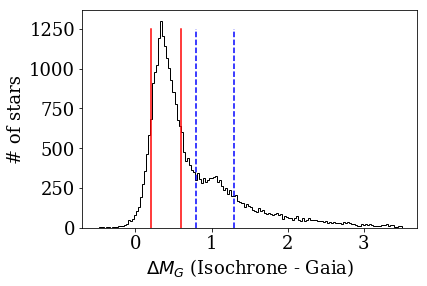

In [19]:
_ = plt.hist(delta_mag[dok], range=(-0.5,3.5), bins=150, histtype='step', lw=1, color='k')
plt.ylabel('# of stars')
plt.xlabel(r'$\Delta M_G$ (Isochrone - Gaia)')

plt.plot([dmag_lims[0][0],dmag_lims[0][0]], [0,1250], c='r')
plt.plot([dmag_lims[0][1],dmag_lims[0][1]], [0,1250], c='r')

plt.plot([dmag_lims[1][0],dmag_lims[1][0]], [0,1250], c='b', linestyle='--')
plt.plot([dmag_lims[1][1],dmag_lims[1][1]], [0,1250], c='b', linestyle='--')

## an oddity?
is there a gradient of rotation period across the main sequence? maybe binaries?

if so, we can get a sharper exploration of the bimodality by selecting only the "lower" bit...?

In [20]:
iso_grid_file = '../iso/parsec/output349228763560.dat'
inames = ('Zini','Age','Mini','Mass','logL','logTe','logg','label','McoreTP',
            'C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo',
            'Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag')
igrid = pd.read_table(iso_grid_file, delim_whitespace=True, header=None, comment='#', names=inames)

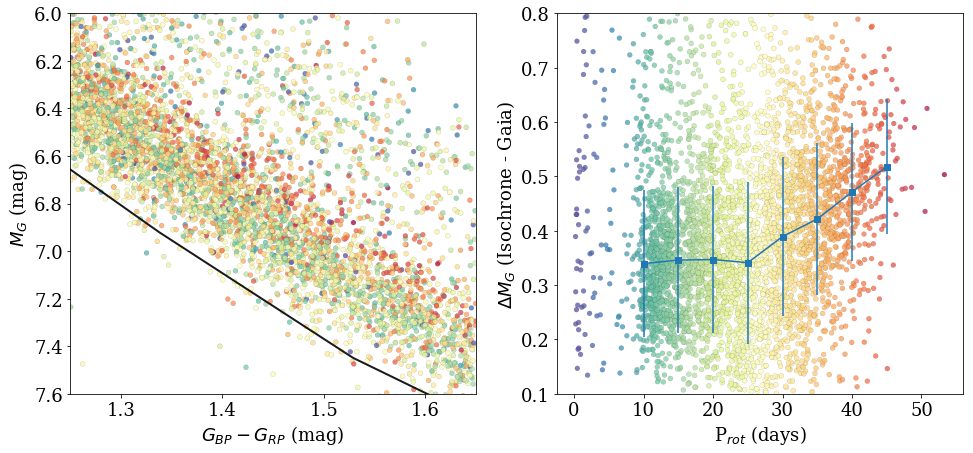

In [213]:
plt.figure(figsize=(16,7))
cm = plt.cm.get_cmap('Spectral_r')


crng = [1.25, 1.65]

# i forget what rb stands for.... but its stuff near the main sequence in a small range of color
rb_ok0 = np.where((df[u'bp_rp'].values[ok] > crng[0]) & (df[u'bp_rp'].values[ok] < crng[1]) & 
                  (df[u'Prot'].values[ok] < 50))[0]

plt.subplot(121)
#----
plt.scatter(df[u'bp_rp'].values[ok][rb_ok0], 
            df[u'phot_g_mean_mag'].values[ok][rb_ok0] - 5. * np.log10(df[u'r_est'].values[ok][rb_ok0])  + 5, 
            c=(df[u'Prot'].values[ok][rb_ok0]), 
            alpha=0.75, s=25, cmap=cm, edgecolors='k', lw=0.1, rasterized=False)

plt.plot(iso5e9['G_BPmag'].values[iok] - iso5e9['G_RPmag'].values[iok], iso5e9['Gmag'].values[iok], 
         c='k', lw=2, alpha=0.9)

# plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
#          mist['Gaia_G_DR2Rev'].values[mist_ms1])

plt.ylim(7.6,6)
plt.xlim(crng[0], crng[1])
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')


#----
plt.subplot(122)
rb_ok = np.where((df[u'bp_rp'].values[ok] > crng[0]) & (df[u'bp_rp'].values[ok] < crng[1]) & 
                  (delta_mag > 0.1) & (delta_mag < 0.8))[0]

plt.scatter(df[u'Prot'].values[ok][rb_ok], delta_mag[rb_ok], c=(df[u'Prot'].values[ok][rb_ok]),
            s=25, alpha=0.75, cmap=cm, edgecolors='k', lw=0.1, rasterized=False)

dy = 5
yy = np.arange(10,50,dy)
xx = np.zeros_like(yy, dtype='float')
xxe = np.zeros_like(yy, dtype='float')
for k in range(len(yy)):
    xok = np.where((df[u'Prot'].values[ok][rb_ok] >= yy[k]-dy/2.) & (df[u'Prot'].values[ok][rb_ok] < (yy[k]+dy/2.)))
    xx[k] = np.nanmedian(delta_mag[rb_ok][xok])
    xxe[k] = np.nanstd(delta_mag[rb_ok][xok]) 

plt.errorbar(yy,xx, yerr=xxe, marker='s')

plt.ylim(0.1, 0.8)
plt.ylabel(r'$\Delta M_G$ (Isochrone - Gaia)')
plt.xlabel('P$_{rot}$ (days)')

plt.savefig('../figures/cmd_zoom'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

In [303]:
print(max(xx) - min(xx),' mag' )

(0.1781971794935493, ' mag')


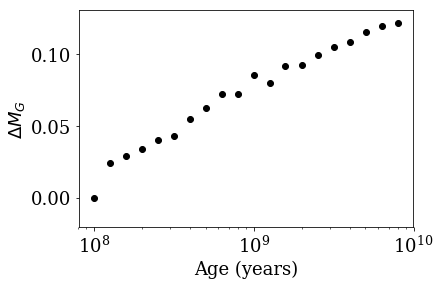

In [23]:
# how much change in mag do we expect from a grid of isochrones (not correcting for offsets)

newMg0 = 7.34344444 # found this manually the first time for the youngest age

color_point = (crng[0] + crng[1])/2.
for aa in np.unique(igrid['Age']):
    aok = np.where((igrid['Age'] == aa) & (igrid['label'] < 2) & 
                   (igrid['G_BPmag'].values - igrid['G_RPmag'].values >= crng[0]) & 
                   (igrid['G_BPmag'].values - igrid['G_RPmag'].values < crng[1]))[0][::-1]
    newMg = np.interp(color_point, igrid['G_BPmag'].values[aok] - 
                      igrid['G_RPmag'].values[aok], igrid['Gmag'].values[aok])
#     print(aa, newMg)
    plt.scatter(aa, newMg0 - newMg,
               c='k')
#     plt.plot(igrid['G_BPmag'].values[aok] - igrid['G_RPmag'].values[aok], igrid['Gmag'].values[aok], '-o', alpha=0.1)

plt.xscale('log')
plt.xlabel('Age (years)')
plt.ylabel(r'$\Delta M_G$ ')
# plt.savefig('../figures/iso_age'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

Text(0,0.5,u'mass (solar)')

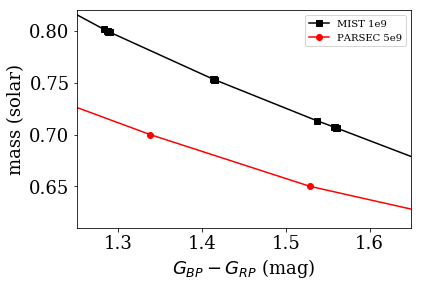

In [273]:
# interesting difference in mass versus color... probably from [Fe/H] differences

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['star_mass'].values[mist_ms1],'-s', label='MIST 1e9', c='k')

plt.plot(iso5e9['G_BPmag'].values[iok] - iso5e9['G_RPmag'].values[iok], iso5e9['Mass'].values[iok],
        '-o', label='PARSEC 5e9', c='r')

plt.legend(fontsize=10)
plt.ylim(.61,.82)
plt.xlim(crng[0], crng[1])
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('mass (solar)')

Text(0,0.5,u'$\\Delta M_G$ ')

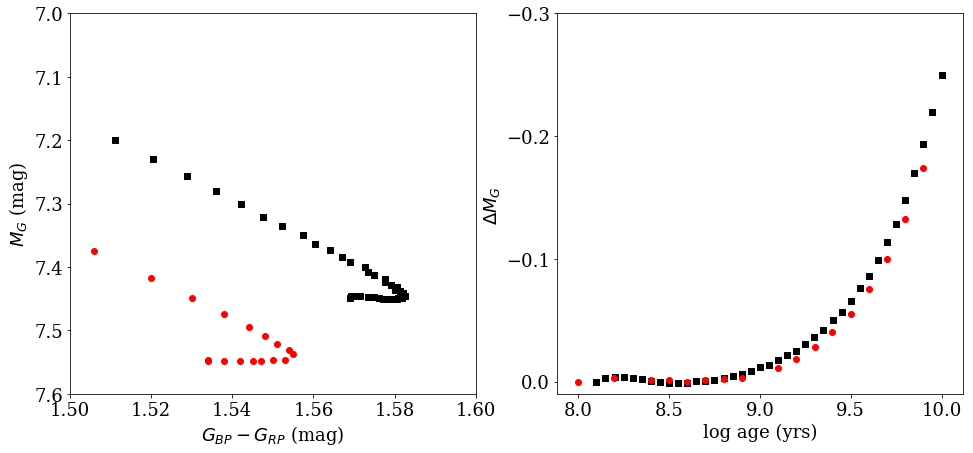

In [310]:
# track a given mass in Delta Mag in all isochrone flavors
plt.figure(figsize=(16,7))
cm = plt.cm.get_cmap('Spectral_r')

M_point = 0.7 # M_solar
plt.subplot(121) # plot the CMD

arng = np.where((mist['log10_isochrone_age_yr'] > 8.1) & (mist['log10_isochrone_age_yr'] <= 10) )
for aa in np.unique(mist['log10_isochrone_age_yr'].values[arng]):
    aok = np.where((mist['log10_isochrone_age_yr'] == aa) & (mist['phase']==0))
    new_BR = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_BP_DR2Rev'].values[aok] - mist['Gaia_RP_DR2Rev'].values[aok])
    new_G = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_G_DR2Rev'].values[aok])

    plt.scatter(new_BR, new_G, marker='s', c='k')

for aa in np.unique(igrid['Age']):
    aok = np.where((igrid['Age'] == aa) & (igrid['label'] < 2) & 
                   (igrid['G_BPmag'].values - igrid['G_RPmag'].values >= crng[0]) & 
                   (igrid['G_BPmag'].values - igrid['G_RPmag'].values < crng[1]))[0][::-1]
    new_BR = np.interp(M_point, igrid['Mass'].values[aok], igrid['G_BPmag'].values[aok] - igrid['G_RPmag'].values[aok])
    new_G = np.interp(M_point, igrid['Mass'].values[aok], igrid['Gmag'].values[aok])

    plt.scatter(new_BR, new_G, marker='o', c='r')


plt.ylim(7.6, 7)
plt.xlim(1.5, 1.6)
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')


## MIST
plt.subplot(122)
new_G0 = 7.44941668207 # found manually the first time
arng = np.where((mist['log10_isochrone_age_yr'] > 8.1) & (mist['log10_isochrone_age_yr'] <= 10) )
for aa in np.unique(mist['log10_isochrone_age_yr'].values[arng]):
    aok = np.where((mist['log10_isochrone_age_yr'] == aa) & (mist['phase']==0))
    new_G = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_G_DR2Rev'].values[aok])
    plt.scatter(aa, new_G-new_G0, marker='s', c='k')
#     print(aa, new_G-new_G0)


    
## PARSEC
new_G0 = 7.549 # found manually the first time
for aa in np.unique(igrid['Age']):
    aok = np.where((igrid['Age'] == aa) & (igrid['label'] < 2) & 
                   (igrid['G_BPmag'].values - igrid['G_RPmag'].values >= crng[0]) & 
                   (igrid['G_BPmag'].values - igrid['G_RPmag'].values < crng[1]))[0][::-1]
    new_G = np.interp(M_point, igrid['Mass'].values[aok], igrid['Gmag'].values[aok])
    plt.scatter(np.log10(aa), new_G-new_G0, marker='o', c='r')
#     print(np.log10(aa), new_G-new_G0)
    
# new_I0 = 5.39910773260039
# new_R0 = 5.771619442665649
# yok = np.where((yapsi['Age'] < 11))
# for aa in np.unique(yapsi['Age'].values[yok]):
#     aok = np.where((yapsi['Age'].values[yok] == aa))
    
#     new_I =  np.interp(M_point, yapsi['M/Msun'].values[yok][aok], 
#                       yapsi['Mv'].values[yok][aok] - yapsi['V-I'].values[yok][aok])
#     new_R =  np.interp(M_point, yapsi['M/Msun'].values[yok][aok], 
#                       yapsi['Mv'].values[yok][aok] - yapsi['V-R'].values[yok][aok])
#     plt.scatter(np.log10(aa)+9, new_I - new_I0, c='b')
#     plt.scatter(np.log10(aa)+9, new_R - new_R0, c='purple')


plt.ylim(0.01, -0.3)
plt.yticks((0, -0.1, -0.2, -0.3))
plt.xlabel('log age (yrs)')
plt.ylabel(r'$\Delta M_G$ ')
# plt.legend(['MIST 1e9', ['PARSEC 5e9']], markers=['s', 'o'])

In [311]:
# MIST: age that crosses ~0.17 mag:
print((10.**9.85) / 1e9)

# parsec: age that crosses ~0.17 mag:
print((10.**9.899) / 1e9)

7.07945784384
7.9250133048


## The Color-Rotation Diagram
This is the meat of what we're after!

The period bimodality *is* there, and most notable for the red stars again.

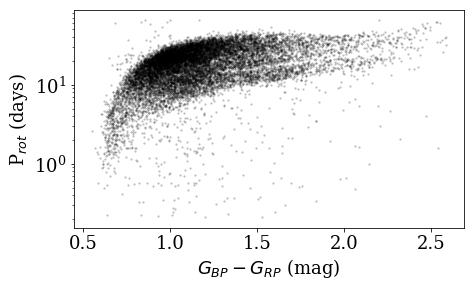

In [25]:
plt.figure(figsize=(7,4))
cm = plt.cm.get_cmap('Spectral')

plt.scatter(df[u'bp_rp'].values[ok][msok], df[u'Prot'].values[ok][msok], 
            s=5, alpha=0.25, c='k', lw=0)

plt.yscale('log')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('P$_{rot}$ (days)');

In [26]:
# plt.figure(figsize=(7,4))
# cm = plt.cm.get_cmap('Spectral')

# plt.scatter(df[u'Teff'].values[ok][msok], df[u'Prot'].values[ok][msok], 
#             s=5, alpha=0.25, c='k', lw=0, rasterized=True)

# plt.yscale('log')
# plt.xlabel('Teff (K)')
# plt.xlim(6600,3000)
# plt.ylabel('P$_{rot}$ (days)')

In [27]:
# plt.figure(figsize=(7,4))
# cm = plt.cm.get_cmap('Spectral')

# plt.scatter(df[u'jmag'].values[ok][msok] - df[u'kmag'].values[ok][msok] , df[u'Prot'].values[ok][msok], 
#             s=5, alpha=0.25, c='k', lw=0, rasterized=True)

# plt.yscale('log')
# plt.xlabel('J-Ks')
# plt.xlim(0.15,1)
# plt.ylabel('P$_{rot}$ (days)')

## Slices in Distance
This is *messier* than with DR1, likely because we're not just limited to the nearest 300pc!

So do what I said I'd do in the DR1 paper... make cuts in distance

In [51]:
dist = df[u'r_est'].values[ok][msok]

# _ = plt.hist(dist, histtype='step', color='k', bins=100)
# plt.xlabel('Dist (pc)')
# plt.ylabel('Number of Stars')

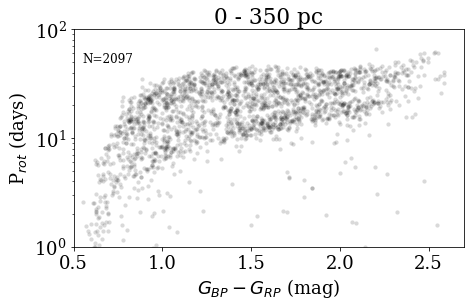

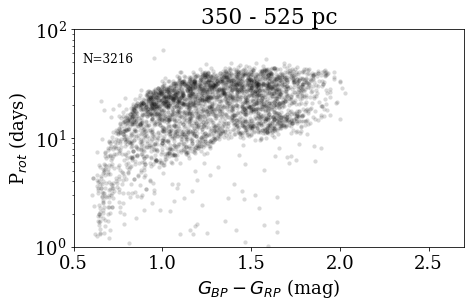

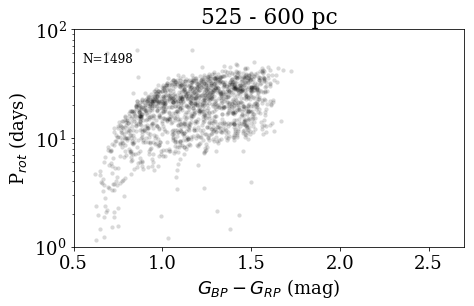

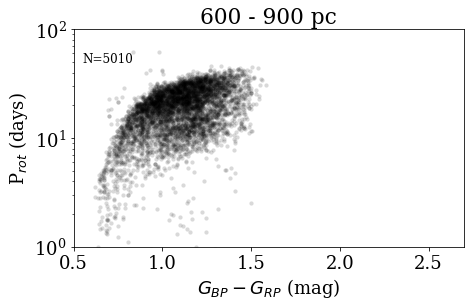

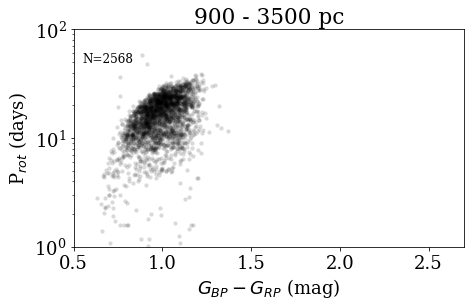

In [30]:
# dbins = np.array([0, 300, 450, 525, 600, 700, 800, 900, 1100, 3500])
dbins = np.array([0, 350, 525, 600, 900, 3500])

for k in range(len(dbins)-1):
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]))
    
    plt.figure(figsize=(7,4))
    plt.scatter(df[u'bp_rp'].values[ok][msok][dd], df[u'Prot'].values[ok][msok][dd], 
                s=18, alpha=0.15, c='k', lw=0, rasterized=False)
    
    plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
    plt.yscale('log')
    plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
    plt.ylabel('P$_{rot}$ (days)');
    plt.xlim(0.5,2.7)
    plt.ylim(1,100)
    plt.title(str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
    plt.savefig('../figures/rot_dist_'+str(dbins[k]) + ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)
    plt.show()

Text(0.5,0,u'P$_{rot}$ (days)')

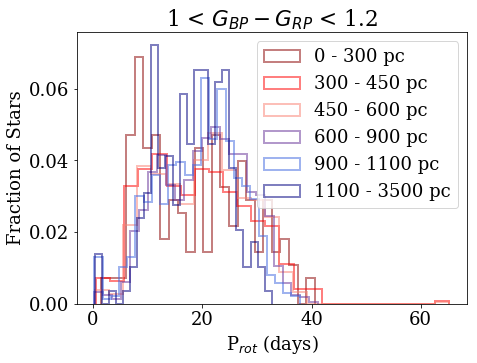

In [53]:
dbins = np.array([0, 300, 450, 600, 900, 1100, 3500])
clr = ['DarkRed', 'red', 'salmon', 'RebeccaPurple', 'RoyalBlue', 'Navy']

plt.figure(figsize=(7,5))

for k in range(0,len(dbins)-1,1):
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]) & 
                  (df[u'bp_rp'].values[ok][msok] >= 1) & (df[u'bp_rp'].values[ok][msok] <= 1.2))
    
    
    _ = plt.hist((df[u'Prot'].values[ok][msok][dd]), histtype='step', bins=25,
                 label=str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc', 
                 normed=True, lw=2, alpha=0.5, color=clr[k])
plt.legend()
plt.title('1 < $G_{BP} - G_{RP}$ < 1.2')
plt.ylabel('Fraction of Stars')
plt.xlabel('P$_{rot}$ (days)')

(0, 1500)

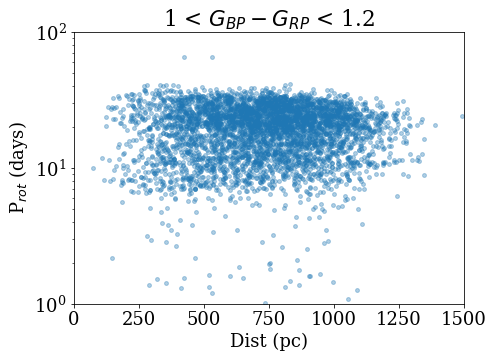

In [52]:
dd = np.where((df[u'bp_rp'].values[ok][msok] >= 1.) & (df[u'bp_rp'].values[ok][msok] <= 1.2))

plt.figure(figsize=(7,5))
plt.scatter(dist[dd], (df[u'Prot'].values[ok][msok][dd]), alpha=0.35, s=15)
plt.yscale('log')
plt.title('1 < $G_{BP} - G_{RP}$ < 1.2')
plt.ylabel('P$_{rot}$ (days)')
plt.xlabel('Dist (pc)')
plt.ylim(1,100)
plt.xlim(0,1500)

## Add Gyrochrones!


In [41]:
def MM09e2(B_V, age):
    ''' 
    Eqn 2 
    http://adsabs.harvard.edu/abs/2009ApJ...695..679M
    '''
    a = 0.50
    b = 0.15
    P = np.sqrt(age) * (np.sqrt(B_V - a)) - b * (B_V - a)
    return P

def MM09e3(B_V, age):
    ''' Eqn 3 '''
    c = 0.77
    d = 0.40
    f = 0.60
    P = age**0.52 * (c * (B_V - d)**f)
    return P

Text(0.5,1,u'1e9yr isochrone')

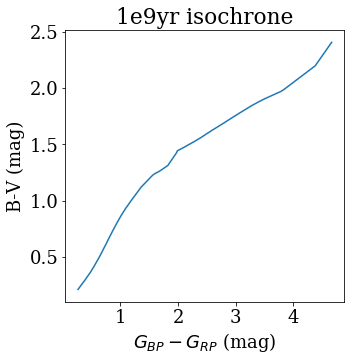

In [42]:
plt.figure(figsize=(5,5))
plt.plot(iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok], 
         iso2['Bmag'].values[iok] - iso2['Vmag'].values[iok])
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('B-V (mag)')
plt.title('1e9yr isochrone')

In [43]:
# now convert these gyrochrones from B-V to GP-RP, or our data to B-V (via an isochrone)
BV_ms = np.interp(df[u'bp_rp'].values[ok], iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok],
                 iso2['Bmag'].values[iok] - iso2['Vmag'].values[iok])


In [50]:
# dbins = np.array([0, 350, 525, 600, 900, 3500])

# for k in range(len(dbins)-1):
#     dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]))
    
#     plt.figure(figsize=(7,4))
#     plt.scatter(BV_ms[msok][dd], df[u'Prot'].values[ok][msok][dd], 
#                 s=18, alpha=0.25, c='k', lw=0)
    
#     B_V_iso = np.arange(0.55,1.8,0.01)

#     P_iso2 = MM09e2(B_V_iso, 600)
#     plt.plot(B_V_iso, P_iso2, c='red')

#     plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
#     plt.yscale('log')
#     plt.xlabel('B-V (mag)')
#     plt.ylabel('P$_{rot}$ (days)');
#     plt.xlim(0.4,1.8)
#     plt.ylim(1,100)
#     plt.title(str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
#     plt.show()

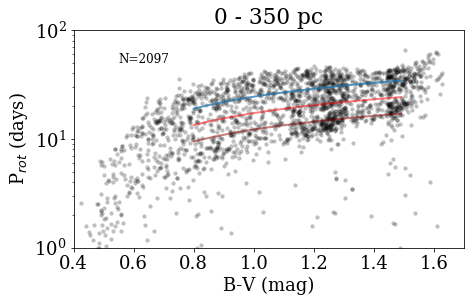

In [45]:
dbins = np.array([0, 350, 525, 600, 900, 3500])

k=0
dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]))

plt.figure(figsize=(7,4))
plt.scatter(BV_ms[msok][dd], df[u'Prot'].values[ok][msok][dd], 
            s=18, alpha=0.25, c='k', lw=0)

B_V_iso = np.arange(0.8,1.5,0.01)

P_iso1 = MM09e2(B_V_iso, 300)
P_iso2 = MM09e2(B_V_iso, 600)
P_iso3 = MM09e2(B_V_iso, 1200)
plt.plot(B_V_iso, P_iso1, c='DarkRed', lw=2, alpha=0.5)
plt.plot(B_V_iso, P_iso2, c='red', lw=2, alpha=0.5)
plt.plot(B_V_iso, P_iso3, lw=2, alpha=0.75)


plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
plt.yscale('log')
plt.xlabel('B-V (mag)')
plt.ylabel('P$_{rot}$ (days)');
plt.xlim(0.4,1.7)
plt.ylim(1,100)
plt.title(str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
plt.savefig('../figures/B_V_rot' + ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

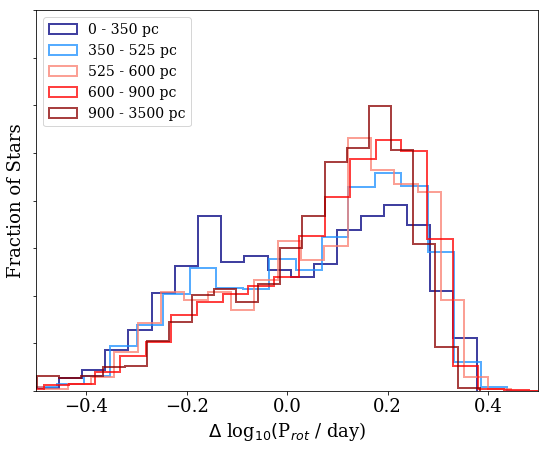

In [46]:
dbins = np.array([0, 350, 525, 600, 900, 3500])

clr = ['DarkRed', 'red', 'salmon', 'DodgerBlue', 'Navy']

fig=plt.figure(figsize=(9,7))
ax = plt.subplot(111)
for k in range(len(dbins)-1):
    # for a restricted range of color (0.7 < B-V < 1.5), subtract off 600Myr gyrochrone
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]) &
                  (BV_ms[msok] >= 0.8) &(BV_ms[msok] <= 1.5))
     
    B_V_iso = np.arange(0.55,1.8,0.01)
    P_iso = MM09e2(B_V_iso, 600)
    plt.plot(B_V_iso, P_iso, c='r')

    rs = np.argsort(P_iso)
    red_P = np.interp(BV_ms[msok][dd], B_V_iso[rs], P_iso[rs])

    _ = plt.hist(np.log10(df[u'Prot'].values[ok][msok][dd]) - np.log10(red_P),
                 histtype='step', bins=50, lw=2, alpha=0.75, color=clr[::-1][k], density=True,
                 label=str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')

plt.legend(fontsize=14, loc='upper left')
plt.xlim(-0.5,0.5)
plt.ylim(0,4)
plt.xlabel(r'$\Delta$ log$_{10} ($P$_{rot}$ / day)')
plt.ylabel('Fraction of Stars')
ax.set_yticklabels('')

plt.savefig('../figures/delta_per'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)